In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Direct access
import s3fs # for models
import fsspec # for era5
# also install the package 'gcsfs' for google cloud storage, but importing is not necessary
import pandas as pd
# from io import BytesIO

# datetime
import datetime as dt
import calendar

# read files
import dask.array as da
import xarray as xr
import h5py

# data process
import numpy as np
import pandas as pd
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed

# land masking
import cartopy.feature as cfeature
from shapely.geometry import Point, MultiPolygon
from shapely.vectorized import contains

# plot
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import cartopy.crs as ccrs
import cartopy.feature as cfeature

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Function to read the file and extract the relevant variables
def read_file(aws_file):
    with xr.open_dataset(aws_file, chunks={'time': 10, 'lat': 90, 'lon': 90}, engine='h5netcdf') as ds:
        t2 = ds.variables['t2'][:]
        lon = ds.variables['longitude'][:]
        lat = ds.variables['latitude'][:]
        time = ds.variables['time'][:]
    return t2, lon, lat, time

# Function to find a file in the NOAA directory
def find_file(model_code, month, day):
    url_prefix = f's3://noaa-oar-mlwp-data/{model_code}/2023/{month}{day}/'
    try:
        files = s3.ls(url_prefix)
        if not files:
            print(f"No files found in {url_prefix}")
            return None

        aws_file = f's3://{files[0]}'  # Use first file
        print(f"Processing file: {aws_file}")
        f = s3.open(aws_file, 'rb')
        return read_file(f)  # Pass S3 URL directly
    except Exception as e:
        print(f"Error processing file: {e}")
        return None

# Function to dynamically create the dd_list based on the month
def days_in_month(month):
    days_in_month = calendar.monthrange(2023, int(month))[1]  # Get the number of days in the month
    return [f"{i:02}" for i in range(1, days_in_month + 1)]

# Function to read and process files sequentially and return data
def sequential_process():
    GRAP_t2_list, FOUR_t2_list, PANG_t2_list = [], [], []
    GRAP_time_list, FOUR_time_list, PANG_time_list = [], [], []
    lon_saved, lat_saved = None, None

    for model in model_list:
        for month in mm_list:
            temp_dd_list = dd_list # days_in_month(month)
            for day in temp_dd_list:
                result = find_file(model, month, day)
                if result:
                    t2, longitude, latitude, time = result
                    if model == 'GRAP_v100':
                        GRAP_t2_list.append(t2)
                        GRAP_time_list.append(time)
                    elif model == 'FOUR_v200':
                        FOUR_t2_list.append(t2)
                        FOUR_time_list.append(time)
                    elif model == 'PANG_v100':
                        PANG_t2_list.append(t2)
                        PANG_time_list.append(time)

                    # Save lon and lat only on the first successful read
                    if lon_saved is None and lat_saved is None:
                        lon_saved, lat_saved = longitude, latitude

    # Return results as a dictionary for better clarity
    return {
        'GRAP': {'t2': GRAP_t2_list, 'time': GRAP_time_list},
        'FOUR': {'t2': FOUR_t2_list, 'time': FOUR_time_list},
        'PANG': {'t2': PANG_t2_list, 'time': PANG_time_list},
        'longitude': lon_saved,
        'latitude': lat_saved
    }

# Define model codes
model_list = ['GRAP_v100', 
              # 'FOUR_v200', 'PANG_v100'
             ]
mm_list = ['06'
           # , '07', '08'
          ]
dd_list = ['01']

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=True)

# Process files sequentially
data = sequential_process()

# Extract the returned data
GRAP_data = data['GRAP']
FOUR_data = data['FOUR']
PANG_data = data['PANG']
longitude = data['longitude']
latitude = data['latitude']

# Print the number of files processed
total_files_processed = len(GRAP_data['t2']) + len(FOUR_data['t2']) + len(PANG_data['t2'])
print(f"Number of files processed: {total_files_processed}")


Processing file: s3://noaa-oar-mlwp-data/GRAP_v100/2023/0601/GRAP_v100_GFS_2023060100_f000_f240_06.nc
Number of files processed: 1


In [3]:
GRAP_data['t2'][0][0,:,:]

<xarray.Variable (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Attributes:
    long_name:  2 metre temperature
    units:      K

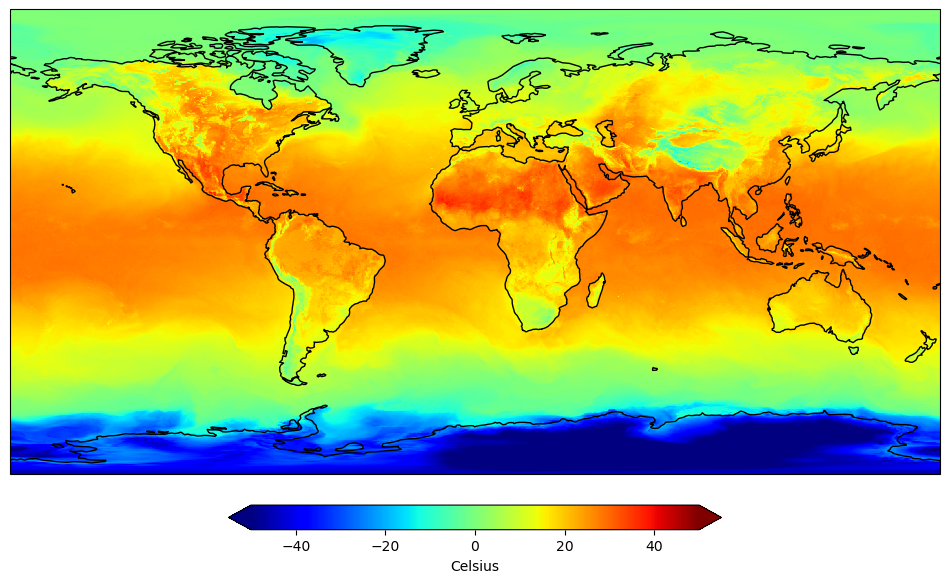

In [5]:
# Plotting the initialization
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)

# Add ocean and land for better contrast
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

# Plot the data
mesh = ax.pcolormesh(longitude, latitude, GRAP_data['t2'][0][0,:,:]-273.15, 
                     cmap='jet', vmin=-50, vmax=50, shading='auto', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, fraction=0.04, orientation='horizontal', pad=0.05, extend='both')
cbar.set_label('Celsius')

# Add titles and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plt.savefig('2m_temp_img.png')
# Show the plot
plt.show()